In [12]:
# visualize_activations.py
# inspect activations of network to see if sparsity holds
# code largely from here: https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md
import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
import os
import scipy.io as sio
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json

In [22]:
# load model based on https://machinelearningmastery.com/save-load-keras-deep-learning-models/

# params
path = '../result/saved_models_Dualnet_mag'
json_name = 'DualNet_mag_indoor_dim384_09_04_model.json'
json_filepath = os.path.join(path, json_name)
model_name = 'DualNet_mag_indoor_dim384_08_19_model.h5'
model_filepath = os.path.join(path, model_name)

# load json file for network structure
json_file = open(json_filepath, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(model_filepath)
print("Loaded model from disk: {}".format(json_name))
print("Number of layers: {}".format(len(loaded_model.layers)))
loaded_model.summary()

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x0000024EA197E390>>
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\client\session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "C:\Anaconda3\lib\site-packages\tensorflow\python\framework\errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 2536386854984


Loaded model from disk: DualNet_mag_indoor_dim384_09_04_model.json
Number of layers: 32
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 32, 32)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 1, 32, 32)    10          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 1, 32, 32)    128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 1, 32, 32)    0           batch_normalization_1[0][0]      
_____________________

In [17]:
# load test data (downlink and uplink)
base_str = "../data/indoor53/ant32/sample/Data100_Hvalin_mag_32ant"
img_channels = 1
img_height = img_width = 32
# magnitude data
mat_down = sio.loadmat('{}_down_sample.mat'.format(base_str))
mat_up = sio.loadmat('{}_up_sample.mat'.format(base_str))
x_val = mat_down['Hur_down'].astype('float32')
x_val_up = mat_up['Hur_up'].astype('float32')
# reshape data
x_val = np.reshape(x_val, (len(x_val), img_channels, img_height, img_width))
x_val_up = np.reshape(x_val_up, (len(x_val_up), img_channels, img_height, img_width))

# evaluate loaded model on test data
loaded_model.compile(optimizer='adam', loss='mse', metrics=['mse'])
score = loaded_model.evaluate([x_val, x_val_up], x_val, verbose=0)
print("%s: %.5f%%" % (loaded_model.metrics_names[1], score[1]*100))

mean_squared_error: 0.00091%


input_1
conv2d_1
batch_normalization_1
leaky_re_lu_1
reshape_1
dense_1
input_2
dense_2
reshape_2
concatenate_1
reshape_3
conv2d_2
batch_normalization_2
leaky_re_lu_2
conv2d_3
batch_normalization_3
leaky_re_lu_3
conv2d_4
batch_normalization_4
add_1
leaky_re_lu_4
conv2d_5
batch_normalization_5
leaky_re_lu_5
conv2d_6
batch_normalization_6
leaky_re_lu_6
conv2d_7
batch_normalization_7
add_2
leaky_re_lu_7
conv2d_8


In [120]:
# visualize activations (https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md)
def check_names(name_list, target):
    # snippet for checking if target does not have name in it
    for name in name_list:
        if name in target:
            return False
    return True

ignore_layers = ['input', 'reshape_1', 'reshape_2', 'dense', 'concatenate']
layer_outputs = []
layer_names = []
print("Adding layer outputs to activation model.")
for layer in loaded_model.layers:
    if check_names(ignore_layers, layer.name):
        print("-> Added {}".format(layer.name))
        layer_outputs.append(layer.output)
        layer_names.append(layer.name)
    else:
        print('-> Ignored {}'.format(layer.name))
# layer_outputs = [layer.output for layer in loaded_model.layers[:32]] # Extracts the outputs of the top 12 layers

activation_model = models.Model(inputs=loaded_model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict([x_val, x_val_up]) # Returns a list of Numpy arrays containing layer activations

Adding layer outputs to activation model.
-> Ignored input_1
-> Added conv2d_1
-> Added batch_normalization_1
-> Added leaky_re_lu_1
-> Ignored reshape_1
-> Ignored dense_1
-> Ignored input_2
-> Ignored dense_2
-> Ignored reshape_2
-> Ignored concatenate_1
-> Added reshape_3
-> Added conv2d_2
-> Added batch_normalization_2
-> Added leaky_re_lu_2
-> Added conv2d_3
-> Added batch_normalization_3
-> Added leaky_re_lu_3
-> Added conv2d_4
-> Added batch_normalization_4
-> Added add_1
-> Added leaky_re_lu_4
-> Added conv2d_5
-> Added batch_normalization_5
-> Added leaky_re_lu_5
-> Added conv2d_6
-> Added batch_normalization_6
-> Added leaky_re_lu_6
-> Added conv2d_7
-> Added batch_normalization_7
-> Added add_2
-> Added leaky_re_lu_7
-> Added conv2d_8


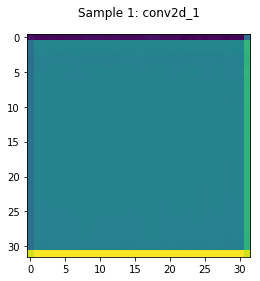

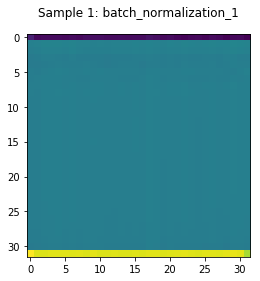

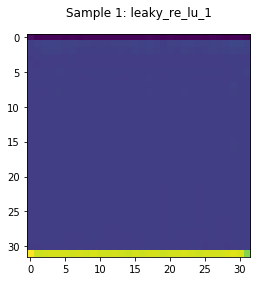

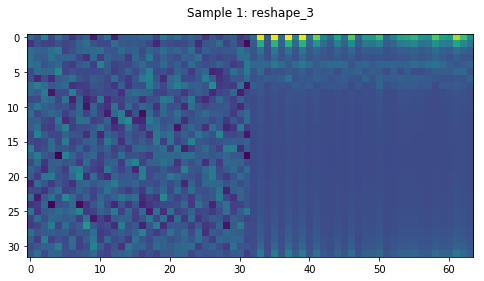

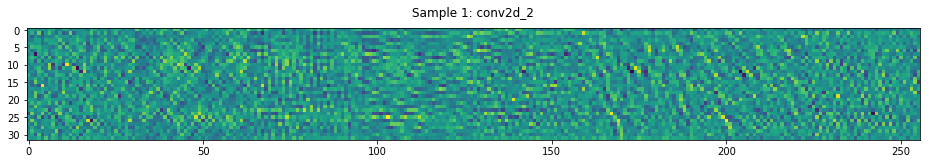

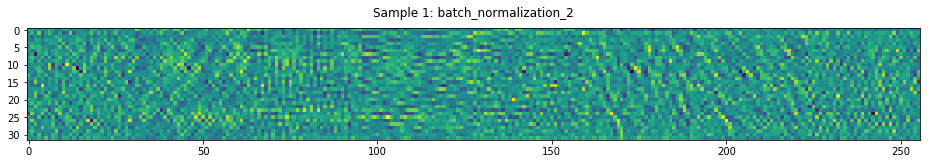

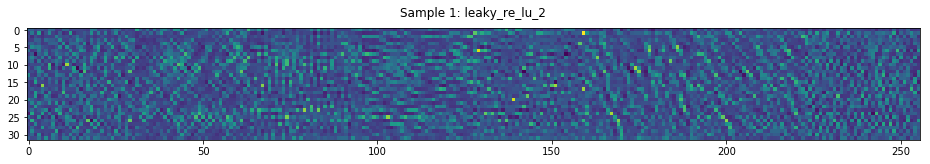

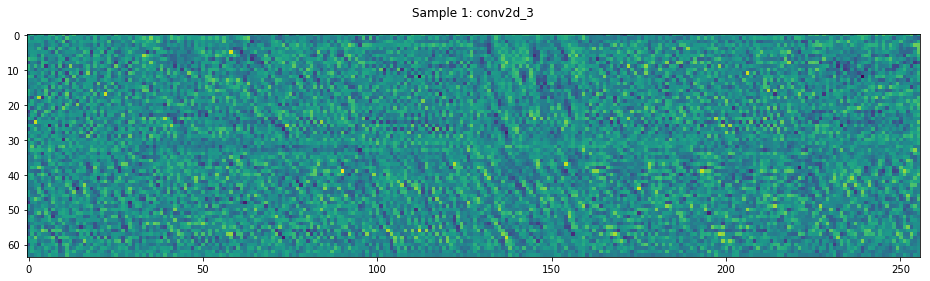

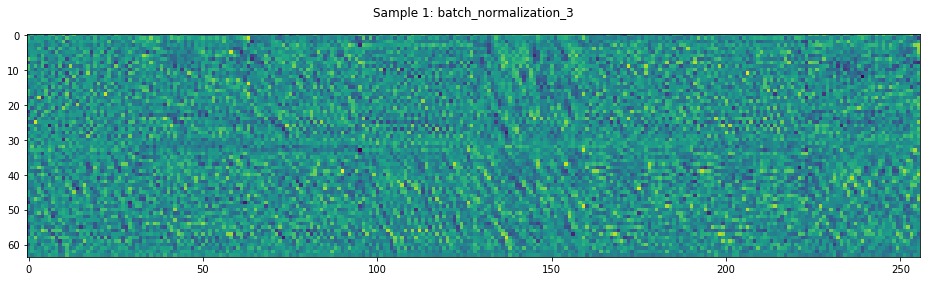

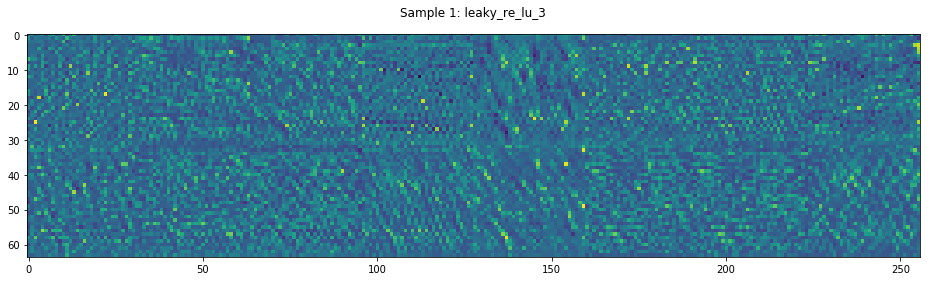

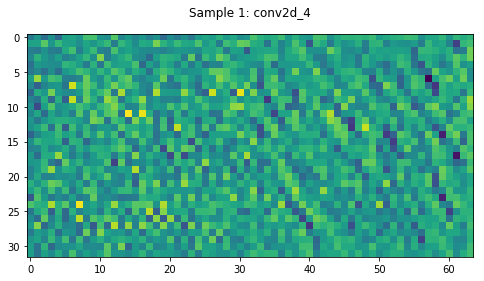

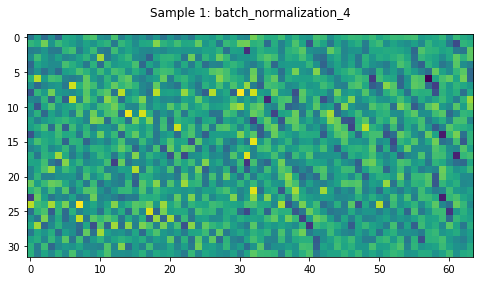

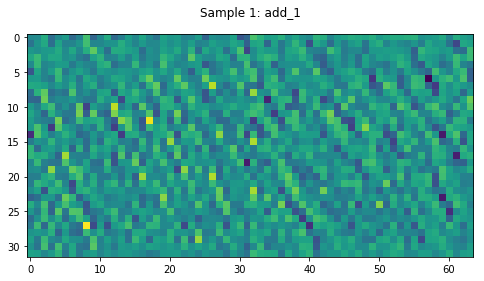

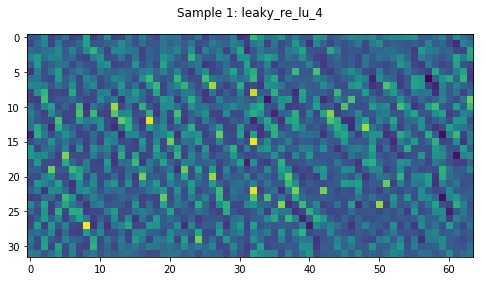

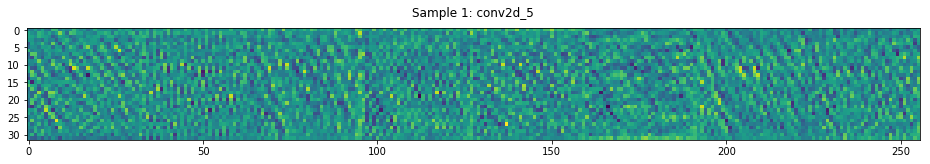

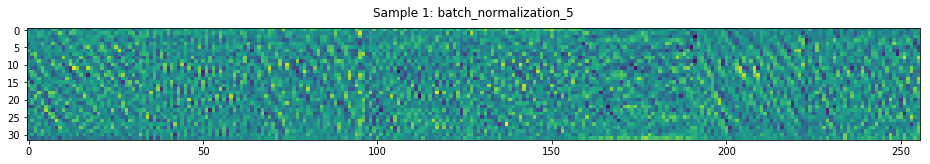

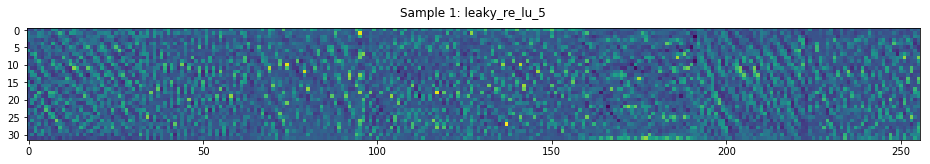

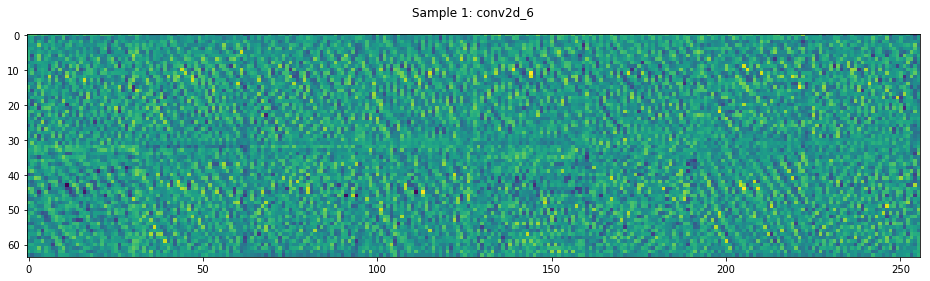

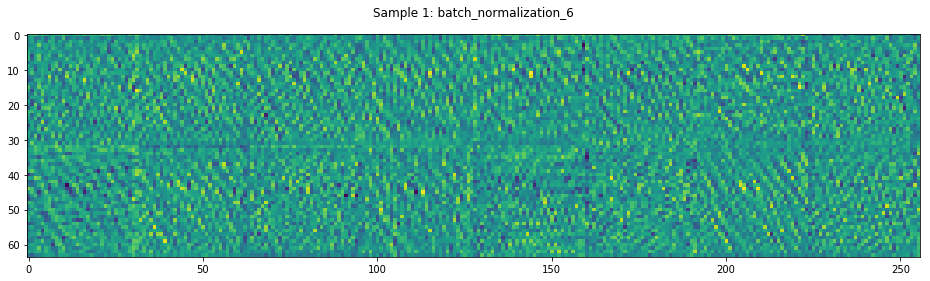

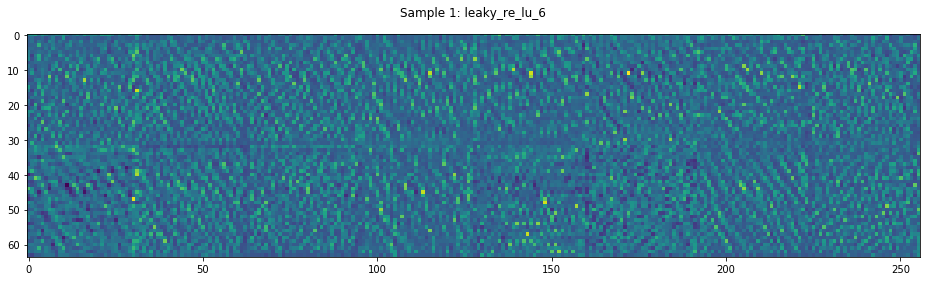

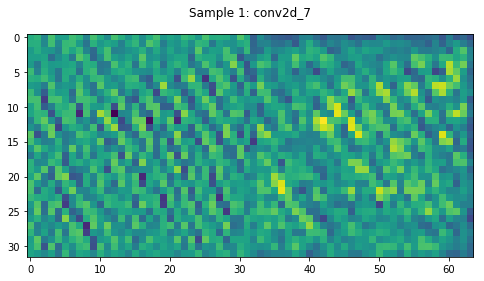

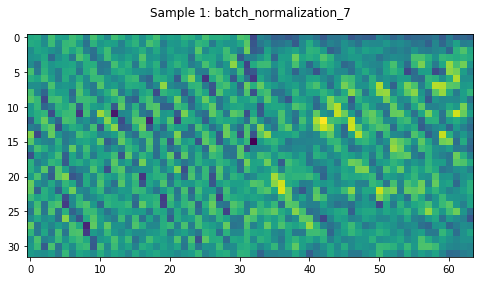

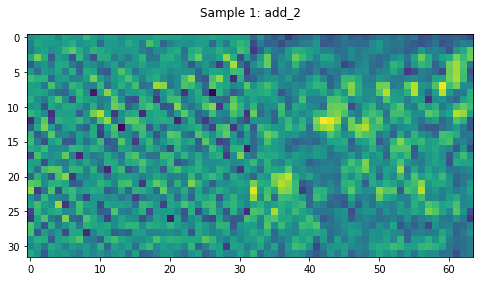

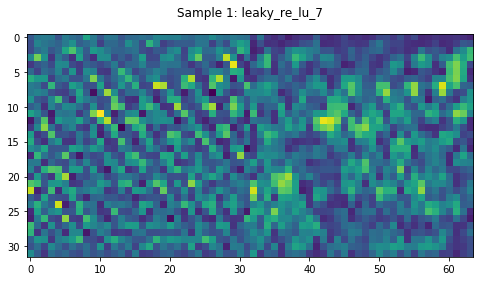

In [137]:
# helper function to normalize image
def normalize_image(image,norm_bool):
    if norm_bool:
        image -= image.mean() # Post-processes the feature to make it visually palatable
        image /= image.std()
        image *= 64
        image += 128
        image = np.clip(image, 0, 255).astype('uint8')
    return image

# predict csi with activation model
batch = 1
im_per_rows = 8
act_len = len(activations)
norm_bool = False
file_dir = 'activations'
file_sub = 's{}'.format(batch)


# concatenate all filters from layers into images for plotting
for i in range(act_len):
    layer_act = activations[i]
    layer_name = layer_names[i]
    filt_num = layer_act.shape[1]
    filt_size = layer_act.shape[-1]
    # print('{} - {} has shape {}'.format(i, layer_name, layer_act.shape))
    rows = filt_num // im_per_rows
    if filt_num == 1:
        im_temp = normalize_image(layer_act[batch, 0, :, :], norm_bool)
    else:
        if filt_num < im_per_rows:
            rows = 1
            cols = filt_num
        else:
            cols = im_per_row
        im_temp = np.zeros((rows*filt_size, cols*filt_size))
        for i in range(filt_num):
            out_temp = normalize_image(layer_act[batch, i, :, :], norm_bool)
            row_ind = (i % rows) * filt_size
            col_ind = (i // rows)  * filt_size
            im_temp[row_ind:row_ind+filt_size,
                    col_ind:col_ind+filt_size] = out_temp

    if i < act_len-1:
        plt.matshow(im_temp, cmap='viridis')
        plt.title("Sample {}: {}".format(batch, layer_name))
        ax = plt.gca()
        ax.tick_params(bottom=True,top=False)
        ax.tick_params(labelbottom=True,labeltop=False)
        plt.savefig(os.path.join(file_dir, file_sub, layer_name))
        plt.show()

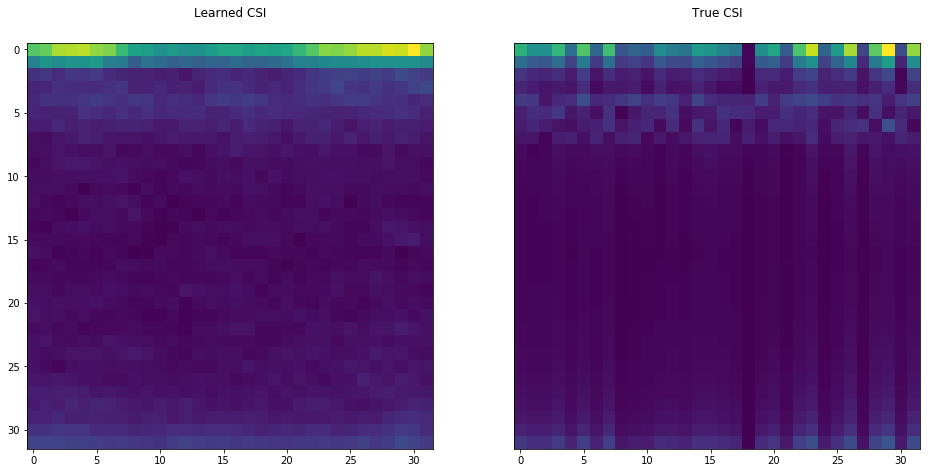

In [146]:
# compare network output with corresponding downlink CSI
fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_size_inches(16,9)
ax1.matshow(im_temp, cmap='viridis')
ax1.tick_params(bottom=True,top=False)
ax1.tick_params(labelbottom=True,labeltop=False)
ax1.set_title("Learned CSI")
x_temp = x_val[batch,:]
x_len = int(x_temp.shape[1])
x_temp = x_temp.reshape(x_len, x_len)
x_temp = normalize_image(x_temp, norm_bool)
ax2.matshow(x_temp, cmap='viridis')
ax2.set_title("True CSI")
ax2.tick_params(bottom=True,top=False,left=False)
ax2.tick_params(labelbottom=True,labeltop=False,labelleft=False)
plt.savefig(os.path.join(file_dir, file_sub, 'compare'))
plt.show()

In [84]:
print(5 % 4)

1
